In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

# Read in COVID19 data from csv

In [2]:
covid_data = pd.read_csv('./data/super_covid_data.csv')
covid_data.head()

,countyFIPS,County Name,State,StateFIPS,2020-01-22_cases,2020-01-23_cases,2020-01-24_cases,2020-01-25_cases,2020-01-26_cases,2020-01-27_cases,...,2023-07-15_deaths,2023-07-16_deaths,2023-07-17_deaths,2023-07-18_deaths,2023-07-19_deaths,2023-07-20_deaths,2023-07-21_deaths,2023-07-22_deaths,2023-07-23_deaths,population
0,0,Statewide Unallocated,AL,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1001,Autauga County,AL,1,0,0,0,0,0,0,...,235,235,235,235,235,235,235,235,235,55869
2,1003,Baldwin County,AL,1,0,0,0,0,0,0,...,731,731,731,731,731,731,731,731,731,223234
3,1005,Barbour County,AL,1,0,0,0,0,0,0,...,104,104,104,104,104,104,104,104,104,24686
4,1007,Bibb County,AL,1,0,0,0,0,0,0,...,111,111,111,111,111,111,111,111,111,22394


# Save the first 4 columns and the last column as metadata for later

In [3]:
metadata_cols = covid_data.columns[:4].append(covid_data.columns[-1:])
metadata = covid_data[metadata_cols]

# Drop metadata columns from the original dataframe


In [4]:
covid_just_data = covid_data.drop(columns=metadata_cols)

# Filter to 'cases only' and 'deaths only' dataframes

In [5]:
covid_just_cases = covid_just_data[[col for col in covid_just_data.columns if 'cases' in col.lower()]]
covid_just_deaths = covid_just_data[[col for col in covid_just_data.columns if 'deaths' in col.lower()]]

# Remove '_cases' and '_deaths' from column titles

In [6]:
covid_just_cases.columns = [col.replace('_cases', '') for col in covid_just_cases.columns]
covid_just_deaths.columns = [col.replace('_deaths', '') for col in covid_just_deaths.columns]

# Convert column names to datetime objects

In [7]:
covid_just_cases.columns = [pd.to_datetime(col) for col in covid_just_cases.columns]
covid_just_deaths.columns = [pd.to_datetime(col) for col in covid_just_deaths.columns]

# Keep only the following date range: 2020-06-01 to 2021-01-03

In [8]:
start_date = pd.to_datetime('2020-06-01')
end_date = pd.to_datetime('2021-01-03')

covid_just_cases = covid_just_cases[[col for col in covid_just_cases.columns if start_date <= col <= end_date]]
covid_just_deaths = covid_just_deaths[[col for col in covid_just_deaths.columns if start_date <= col <= end_date]]

# Group by week

In [9]:
cases_last_date = covid_just_cases.iloc[:, -1:]
covid_just_cases_weekly = covid_just_cases.loc[:, ::7]
covid_just_cases_weekly = pd.concat([covid_just_cases_weekly, cases_last_date], axis=1)

deaths_last_date = covid_just_deaths.iloc[:, -1:]
covid_just_deaths_weekly = covid_just_deaths.loc[:, ::7]
covid_just_deaths_weekly = pd.concat([covid_just_deaths_weekly, deaths_last_date], axis=1)

# Add metadata back to the dataframes

In [10]:
covid_cases_weekly = pd.concat([metadata, covid_just_cases_weekly], axis=1)
covid_deaths_weekly = pd.concat([metadata, covid_just_deaths_weekly], axis=1)

In [11]:
covid_cases_weekly.to_csv('./data/covid_cases_weekly', index=False)
covid_deaths_weekly.to_csv('./data/covid_deaths_weekly', index=False)

# Define function to generate mean and median stats for a given state

In [12]:
def gen_stats(state_abbr, weekly_data, norm=1):
    state_weekly_data = weekly_data[weekly_data['State'] == state_abbr]
    state_pop = state_weekly_data['population'].sum()
    state_weekly_data = state_weekly_data.drop(columns=['State', 'StateFIPS', 'population', 'County Name', 'countyFIPS'])
    normalized_data = state_weekly_data.div(state_pop, axis=0) * norm
    stats = normalized_data.agg(['mean', 'median'])
    return stats.T

# Determine the top 5 most populated states, to compare their mean and median cases and deaths

In [13]:
top_5_populous_states = covid_data.groupby('State')['population'].sum().sort_values(ascending=False).head().index
normalization_factor = 100000

# Plot normalized mean cases for top 5 populous states


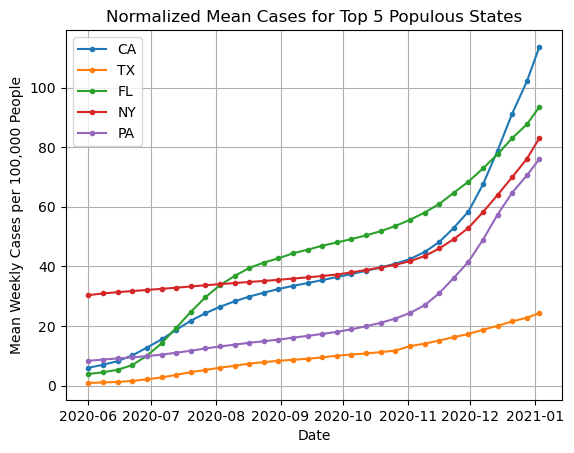

In [14]:
fig, ax = plt.subplots()
for state in top_5_populous_states:
    state_data = gen_stats(state, covid_cases_weekly, normalization_factor)
    ax.plot(state_data.index, state_data['mean'], label=state, marker='.')

ax.legend()
ax.title.set_text('Normalized Mean Cases for Top 5 Populous States')
ax.set_xlabel('Date')
ax.set_ylabel('Mean Weekly Cases per 100,000 People')
ax.grid()
plt.show()

# Plot normalized median cases for top 5 populous states


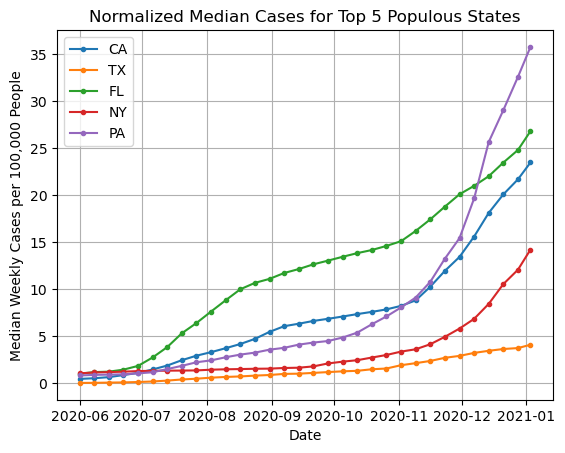

In [15]:
fig, ax = plt.subplots()
for state in top_5_populous_states:
    state_data = gen_stats(state, covid_cases_weekly, normalization_factor)
    ax.plot(state_data.index, state_data['median'], label=state, marker='.')

ax.legend()
ax.title.set_text('Normalized Median Cases for Top 5 Populous States')
ax.set_xlabel('Date')
ax.set_ylabel('Median Weekly Cases per 100,000 People')
ax.grid()
plt.show()

# Plot normalized mean deaths for top 5 populous states


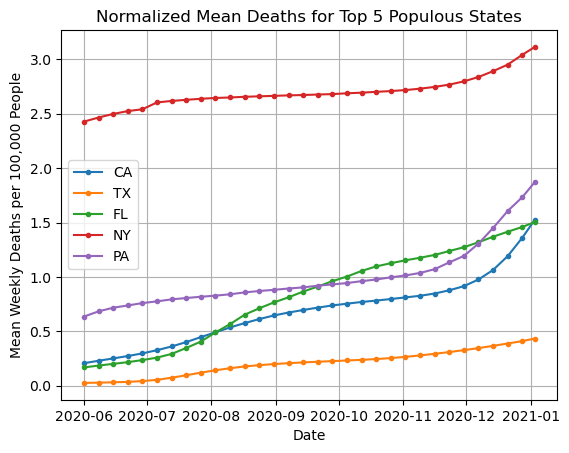

In [16]:
fig, ax = plt.subplots()
for state in top_5_populous_states:
    state_data = gen_stats(state, covid_deaths_weekly, normalization_factor)
    ax.plot(state_data.index, state_data['mean'], label=state, marker='.')

ax.legend()
ax.title.set_text('Normalized Mean Deaths for Top 5 Populous States')
ax.set_xlabel('Date')
ax.set_ylabel('Mean Weekly Deaths per 100,000 People')
ax.grid()
plt.show()

# Plot normalized median deaths for top 5 populous states


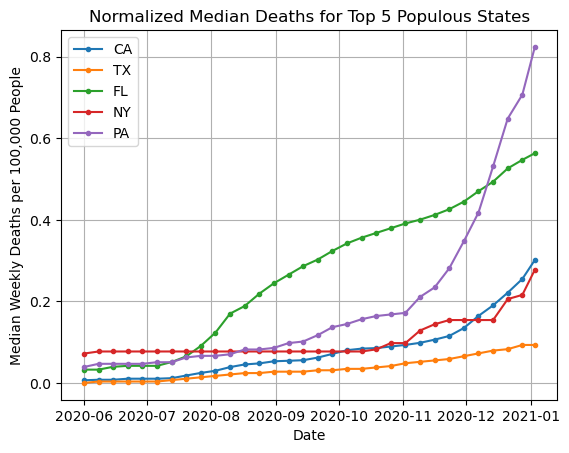

In [17]:
fig, ax = plt.subplots()
for state in top_5_populous_states:
    state_data = gen_stats(state, covid_deaths_weekly, normalization_factor)
    ax.plot(state_data.index, state_data['median'], label=state, marker='.')

ax.legend()
ax.title.set_text('Normalized Median Deaths for Top 5 Populous States')
ax.set_xlabel('Date')
ax.set_ylabel('Median Weekly Deaths per 100,000 People')
ax.grid()
plt.show()

# Discussion on State data:

There are a lot of interesting trends in the data. For example, the mean cases in California are the highest by the end of 2020, but the median is only the third highest. This suggests that there are a few counties with very high case counts that are skewing the mean. In contrast, Texas has the lowest mean and median cases of the top 5 populous states. This suggests that the cases are more evenly distributed across the state. The deaths data is very interesting, as it shows that the average death rate in New York was much higher than the other states, but the median death rate was middling. This suggests that there were a few counties in New York with very high death rates that were skewing the mean. This is likely due to a few lower-income communities with very high populations in New York, that would have worse living conditions and less access to healthcare. 

The largest peak is at the end of the data, which is likely due to the holiday season. People were likely traveling and gathering in large groups, which would have caused a spike in cases and deaths. This follows the overall trend of the U.S. statistics, which saw a large spike in cases and deaths in November and December.

# In New York, find the 5 counties with the highest average deaths


In [18]:
ny_cases_data = covid_cases_weekly[covid_cases_weekly['State'] == 'NY']
ny_death_data = covid_deaths_weekly[covid_deaths_weekly['State'] == 'NY']

# Save county populations for later
ny_county_pops = ny_death_data.loc[:, ['County Name', 'population']]
ny_county_pops.set_index('County Name', inplace=True)

ny_death_data = ny_death_data.drop(columns=['State', 'StateFIPS', 'population', 'countyFIPS'])
ny_death_data.set_index(['County Name'], inplace=True)
ny_death_data['mean'] = ny_death_data.mean(axis=1)
top_5_counties = ny_death_data.sort_values(by='mean', ascending=False).head().index

ny_cases_data = ny_cases_data.drop(columns=['State', 'StateFIPS', 'population', 'countyFIPS'])
ny_cases_data.set_index(['County Name'], inplace=True)

ny_cases_data = ny_cases_data.T
ny_death_data = ny_death_data.drop(columns='mean').T

# Plot the (raw) deaths for top 5 counties in New York

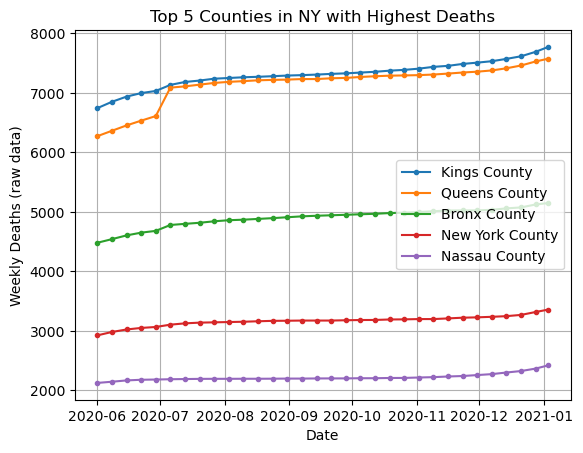

In [19]:
fig, ax = plt.subplots()
for county in top_5_counties:
    ax.plot(ny_death_data.index, ny_death_data[county], label=county, marker='.')

ax.legend()
ax.title.set_text('Top 5 Counties in NY with Highest Deaths')
ax.set_xlabel('Date')
ax.set_ylabel('Weekly Deaths (raw data)')
ax.grid()
plt.show()

# Plot the log-normalized deaths for top 5 counties in New York

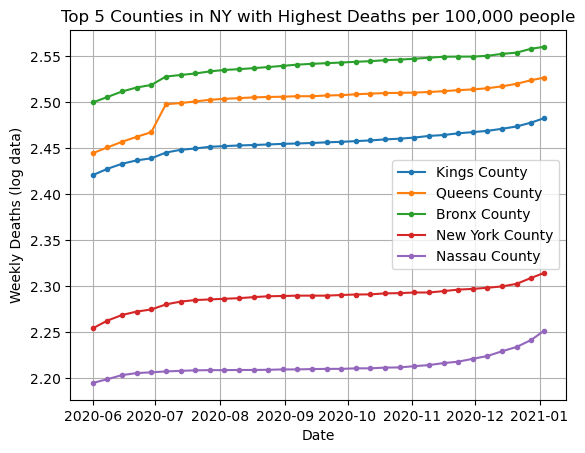

In [20]:
fig, ax = plt.subplots()
for county in top_5_counties:
    county_pop = ny_county_pops.loc[county].iloc[0]
    normalized = np.log10(ny_death_data[county].div(county_pop) * 100_000)
    ax.plot(ny_death_data.index, normalized, label=county, marker='.')

ax.legend()
ax.title.set_text('Top 5 Counties in NY with Highest Deaths per 100,000 people')
ax.set_xlabel('Date')
ax.set_ylabel('Weekly Deaths (log data)')
ax.grid()
plt.show()

# Plot the (raw) cases for top 5 counties in New York

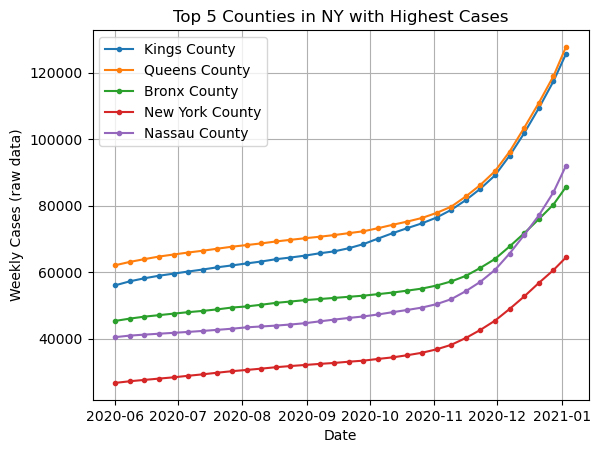

In [21]:
fig, ax = plt.subplots()
for county in top_5_counties:
    ax.plot(ny_cases_data.index, ny_cases_data[county], label=county, marker='.')

ax.legend()
ax.title.set_text('Top 5 Counties in NY with Highest Cases')
ax.set_xlabel('Date')
ax.set_ylabel('Weekly Cases (raw data)')
ax.grid()
plt.show()

# Plot the log-normalized cases for top 5 counties in New York

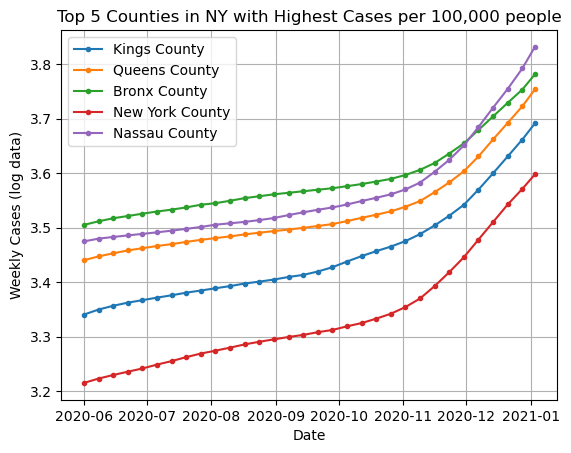

In [22]:
fig, ax = plt.subplots()
for county in top_5_counties:
    county_pop = ny_county_pops.loc[county].iloc[0]
    normalized = np.log10(ny_cases_data[county].div(county_pop) * 100_000)
    ax.plot(ny_cases_data.index, normalized, label=county, marker='.')

ax.legend()
ax.title.set_text('Top 5 Counties in NY with Highest Cases per 100,000 people')
ax.set_xlabel('Date')
ax.set_ylabel('Weekly Cases (log data)')
ax.grid()
plt.show()

# Discussion on County data:

When compared to the state data, we can see basically the same shape, with a surge beginning around the holiday season. Strangely, in Queens, there is a large spike in Deaths in July. This is likely just a data error, as there is no corresponding spike in cases. It is possible that many deaths were retroactively attributed to Covid at that time, but that is just a guess.